# feature_generation
En este notebook se generaran, por secciones, las features a ser utilizadas. Se seguira por cada una el siguiente proceso:

1. Primero generamos las features.
2. Guardamos en un `.csv` las features de una determinada categoria por separado (con el objetivo de poder armar el dataframe que queramos con las features que seleccionemos).
3. Se hardcodea un diccionario que tiene las distintas features generadas con distintos metodos para cada categoria. La idea es poder probar luego que alternativa es mejor para cada feature (es decir, si para tipodepropiedad por ejemplo utilizamos OHE, Binary Encoding, Mean Encoding, etc.)

**IMPORTANTE:** NO es necesario ejecutar todo el notebook cada vez que se realice un entrenamiento, ya que esto es un proceso que cuesta tiempo. Para evitar esto es que guardamos los `csv`'s y los leeremos directamente. Ejecutar **solamente** las secciones que se deseen para generar los `csv` correspondientes.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import nbimporter
import pre_processing

Importing Jupyter notebook from pre_processing.ipynb
Importing Jupyter notebook from feature_generation.ipynb


<hr>

### Funciones auxiliares

In [3]:
def corr(df):
    return df.corr()['precio'].sort_values(ascending=False)[1:]

In [4]:
def aniomes(anio, mes):
    if len(str(mes)) == 1:
        return int(str(anio)+'0'+str(mes))
    return int(str(anio)+str(mes))

In [5]:
def aniomesdia(anio, mes, dia):
    anio= str(anio)
    mes= str(mes)
    dia= str(dia)
    
    if len(mes) == 1:
        mes = '0'+mes
    if len(dia) == 1:
        dia = '0'+dia
    
    return int(anio+mes+dia)

In [6]:
def aniomesdia(dt):
    anio= str(dt.year)
    mes= str(dt.month)
    dia= str(dt.day)
    
    if len(mes) == 1:
        mes = '0'+mes
    if len(dia) == 1:
        dia = '0'+dia
        
    return int(anio+mes+dia)
    

In [7]:
def contiene_indicadores(descripcion, indicadores):
    for indicador in indicadores:
        if indicador in str(descripcion).lower():
            return 1
    return 0

In [8]:
def binning_habitaciones(x):
    if (x==-1):
        return 'unknown'
    elif x==1:
        return 'monoambiente'
    elif (x==2):
        return 'dos ambientes'
    elif (x==3):
        return 'tres ambientes'
    elif (x==4):
        return 'cuatro ambientes'
    elif (x==5):
        return 'cinco ambientes'
    else:
        return 'mas de 5 ambientes'

In [9]:
def binning_antiguedad_1(x):
    if (x==-1):
        return 'unknown'
    elif x==0:
        return 'new'
    elif (x<=5):
        return '0 a 5'
    elif (x<=10):
        return '5 a 10'
    elif (x<=15):
        return '10 a 15'
    elif (x<=20):
        return '15 a 20'
    elif (x<=30):
        return '20 a 30'
    elif (x<=50):
        return '30 a 50'
    else:
        return '+50'
    

In [10]:
def binning_antiguedad_2(x):
    if (x==-1):
        return 'unknown'
    elif x==0:
        return 'new'
    elif (x<=10):
        return 'hasta 10'
    else:
        return 'mas de 10'
    

In [11]:
def posee_volcan_cerca(ubicacion, radio_cercania_km):
    if ubicacion == 9999:
        return np.nan
    for volcan in volcanes:
        dist = haversine(ubicacion, volcan)
        if dist<radio_cercania_km:
            return 1
    return 0

In [12]:
def cantidad_volcanes_cerca(ubicacion, radio_cercania_km):
    if ubicacion == 9999:
        return np.nan
    cantidad = 0
    for volcan in volcanes:
        dist = haversine(ubicacion, volcan)
        if dist<radio_cercania_km:
            cantidad+=1
    return cantidad

In [13]:
filas_train = 240000
filas_test = 60000

<hr>

# Desarollo

In [14]:
df = pre_processing.load_appended_dataset()

<hr>

# Tratamiento de variables importantes con nulos

### Metros cubiertos y totales
`metrostotales` es una categoria muy importante, asi como `metrostotales`. Es la principal feature que determina el precio de una propiedad. Lamentablemente, muchas propiedades no tienen datos en estas filas o tienen datos inconsistentes. En esta seccion analizaremos que hacer con esto.

###### Outliers
Ademas de poseer muchos nulos, el dataset tambien posee datos que, por una razon u otra, no tienen sentido. El objetivo de esta seccion es, ya que no podemos eliminarlos porque perderiamos mas de la mitad de los datos y para entrenar esto no tiene sentido, decidimos generar features que indiquen si la fila presenta o no algun dato sin sentido.

In [82]:
dicc_metros = {}
dicc_metros_types = {}

df_metros = df[['metroscubiertos', 'metrostotales']].copy()
df_metros.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 254099 to 72612
Data columns (total 2 columns):
metroscubiertos    278301 non-null float64
metrostotales      235878 non-null float64
dtypes: float64(2)
memory usage: 6.9 MB


In [83]:
# Generamos columna que nos diga si los metros totales son confiables.

In [84]:
df_metros['metrostotales_confiables'] = df_metros.apply(lambda x: 1 if ((x['metrostotales'] > x['metroscubiertos']) & (x['metroscubiertos'] > 0)) else 0, axis=1)

In [85]:
df_metros['metrostotales_confiables'].sum()

78794

In [86]:
# Vemos que solo en 80.000 datos de 300.000 (!!!) tiene sentido utilizar los metros totales.
# Vamos a tomar una serie de medidas para rellenar los nulos en estos campos, para tener mas informacion.
# Son consideraciones que pueden ser erroneas, pero sera un intento por salvar los datos.

Vemos que solo en 80.000 datos de 300.000 (!!!) tiene sentido utilizar los metros totales.
Vamos a tomar una serie de medidas para rellenar los nulos en estos campos, para tener mas informacion. Son consideraciones que pueden ser erroneas, pero sera un intento por salvar los datos.

- CASO 1: Los `metroscubiertos` son distintos de `nan`, pero los `metrostotales` son `nan`.
- CASO 2: Los `metroscubiertos` son distintos de `nan`, los `metrostotales` son menores que los cubiertos.
- CASO 3: Los `metroscubiertos` son `nan`, pero los `metrostotales` son distintos de `nan`.

In [87]:
df_metros.loc[(df_metros['metroscubiertos'].isnull()) & (df_metros['metrostotales'].isnull())]

,metroscubiertos,metrostotales,metrostotales_confiables
id,,,


In [88]:
# OBSERVACION! Vemos que no hay propiedades que tengan ambas informaciones faltantes. Esto nos permite tomar como
# primer opcion, solucionar los casos llenando la info del faltante con la del presente.

In [89]:
#CASO 3
df_metros['metroscubiertos_alt'] = df_metros['metroscubiertos'].fillna(df_metros['metrostotales'])

In [90]:
# Esta alternativa parece tener mucho sentido, ya que puede pasar que haya gente que directamente ponga el dato
# en metros totales, y no complete los cubiertos.

# En el CASO 1 hay que tener un poco mas de cuidado, ya que los metros totales son por definicion MAYORES O
# IGUALES a los cubiertos. En esta primer alternativa, los consideraremos iguales en el caso de nans.

In [91]:
df_metros['metrostotales_alt'] = df_metros['metrostotales'].fillna(df_metros['metroscubiertos'])

In [92]:
# regeneramos la columna de metros confiables
df_metros['metrostotales_confiables_alt'] = df_metros.apply(lambda x: 1 if ((x['metrostotales_alt'] > x['metroscubiertos_alt']) & (x['metroscubiertos_alt'] > 0)) else 0, axis=1)

In [93]:
# En este caso ya solucionamos entonces caso 1 y 3. Ahora nos falta ver que hacemos con las propiedades que tienen
# metros totales MENORES a los cubiertos...

In [94]:
df_metros.loc[(df_metros['metroscubiertos'] > df_metros['metrostotales'])].shape[0]

88101

In [95]:
# Vemos que tenemos 88 mil datos con este problema. Vamos a analizar que tanta diferencia hay...

Como interpretar esto? Proponemos tres ideas:

**Idea 1**: la carga se realizo al reves, es decir que los metros cubiertos serian los metros totales, y los metros totales los metros cubiertos.

**Idea 2**: los metros totales representan en realidad, metros descubiertos. Por lo que los metros totales los re-calculamos como la suma entre los totales y los cubiertos.

In [96]:
df_metros.head()

,metroscubiertos,metrostotales,metrostotales_confiables,metroscubiertos_alt,metrostotales_alt,metrostotales_confiables_alt
id,,,,,,
254099,80.0,80.0,0,80.0,80.0,0
53461,268.0,180.0,0,268.0,180.0,0
247984,144.0,166.0,1,144.0,166.0,1
209067,63.0,67.0,1,63.0,67.0,1
185997,95.0,95.0,0,95.0,95.0,0


In [97]:
df_metros.loc[(df_metros['metroscubiertos_alt'] > df_metros['metrostotales_alt'])].shape[0]

88101

In [98]:
# idea 1: los metros cubiertos serian los metros totales, y los metros totales los metros cubiertos.

df_metros['metrostotales_i1'] = df_metros.apply(lambda x: (x['metroscubiertos_alt']) if (x['metroscubiertos_alt'] > x['metrostotales_alt']) else (x['metrostotales_alt']), axis=1)
df_metros['metroscubiertos_i1'] = df_metros.apply(lambda x: (x['metrostotales_alt']) if (x['metroscubiertos_alt'] > x['metrostotales_alt']) else (x['metroscubiertos_alt']), axis=1)

In [99]:
# idea 2: los metros totales son metros descubiertos, entonces metrostotales = metroscubiertos + metrostotales
df_metros['metrostotales_i2'] = df_metros.apply(lambda x: (x['metrostotales_alt'] + x['metroscubiertos_alt']) if (x['metroscubiertos_alt'] > x['metrostotales_alt']) else (x['metrostotales_alt']), axis=1)

#### FEATURES NUEVAS DOCUMENTADAS

- `metrostotales_confiables`: dato valido y con sentido, considerando las features originales.
- `metrostotales_confiables_alt`: dato valido y con sentido, considerando las features _alt.

- `metroscubiertos_alt`: llenar los nulos de metros cubiertos con el dato de metros totales.
- `metrostotales_alt`: llenar los nulos de metros totales con el dato de metros cubiertos.
- `metroscubiertos_i1`: si los metros cubiertos eran mayores a los totales, se invierten.
- `metrostotales_i1`: si los metros cubiertos eran mayores a los totales, se invierten.
- `metrostotales_i2`: se considera que si los metros cubiertos son mayores a los totales, entonces en realidad lo que habia en totales eran metros descubiertos. Se calcula la suma.


In [100]:
df_metros.drop(['metroscubiertos', 'metrostotales'], axis=1, inplace=True)

In [101]:
dicc_metros_types['bernoulli'] = ['metrostotales_confiables', 'metrostotales_confiables_alt']
dicc_metros_types['uint16'] = ['metroscubiertos_alt', 'metrostotales_alt', 'metrostotales_i1',
                             'metroscubiertos_i1', 'metrostotales_i2']

In [102]:
# guardamos las features en el diccionario:
['metrostotales_confiables', 'metroscubiertos_alt', 'metrostotales_alt',
 'metrostotales_i1', 'metroscubiertos_i1', 'metrostotales_i2', 'metrostotales_confiables_alt']

dicc_metros[0] = ['metroscubiertos_alt', 'metrostotales_alt']
dicc_metros[1] = ['metroscubiertos_alt', 'metrostotales_alt', 'metrostotales_confiables_alt']
dicc_metros[2] = ['metroscubiertos_i1', 'metrostotales_i1']
dicc_metros[3] = ['metroscubiertos_i1', 'metrostotales_i1', 'metrostotales_confiables_alt']
dicc_metros[4] = ['metroscubiertos_alt', 'metrostotales_i2']
dicc_metros[5] = ['metroscubiertos_alt', 'metrostotales_i2', 'metrostotales_confiables_alt']

# ME LA JUEGO QUE LA MEJOR ES LA [3] -mau

In [103]:
# guardamos todo lo generado
df_metros.to_csv('features/metros.csv')

In [104]:
dicc_metros_types

{'bernoulli': ['metrostotales_confiables', 'metrostotales_confiables_alt'],
 'uint16': ['metroscubiertos_alt',
  'metrostotales_alt',
  'metrostotales_i1',
  'metroscubiertos_i1',
  'metrostotales_i2']}

In [105]:
def get_dicc_metros():
    return {0: ['metroscubiertos_alt', 'metrostotales_alt'],
 1: ['metroscubiertos_alt',
  'metrostotales_alt',
  'metrostotales_confiables_alt'],
 2: ['metroscubiertos_i1', 'metrostotales_i1'],
 3: ['metroscubiertos_i1', 'metrostotales_i1', 'metrostotales_confiables_alt'],
 4: ['metroscubiertos_alt', 'metrostotales_i2'],
 5: ['metroscubiertos_alt',
  'metrostotales_i2',
  'metrostotales_confiables_alt']}

In [106]:
def get_dicc_metros_types():
    return {'bernoulli': ['metrostotales_confiables', 'metrostotales_confiables_alt'],
 'uint16': ['metroscubiertos_alt',
  'metrostotales_alt',
  'metrostotales_i1',
  'metroscubiertos_i1',
  'metrostotales_i2']}

# Encoding de variables categoricas

### TIPO DE PROPIEDAD

In [107]:
# En el TP1 vimos que la mayoria de las propiedades eran casas o departamentos. Vamos a chequear esto:
dicc_tipodepropiedad = {}
dicc_tipodepropiedad_types = {}

df_tipodepropiedad = df[['tipodepropiedad', 'titulo']].copy()
df_tipodepropiedad['tipodepropiedad'].value_counts(normalize=True)[:10]

Casa                  0.590544
Apartamento           0.238615
Casa en condominio    0.080708
Terreno               0.041307
Local Comercial       0.012822
Oficina comercial     0.007188
Bodega comercial      0.005888
Edificio              0.005801
Terreno comercial     0.005534
Casa uso de suelo     0.003101
Name: tipodepropiedad, dtype: float64

In [108]:
# Vemos que un 80% de las propiedades son casas o apartamentos. En vista de esto, propondremos distintos tipos
# de encoding para los tipos de propiedad.

# Antes de encodear, vamos a agrupar las categorias minoritarias y las que sean similares. Analicemos:

In [109]:
# Aca podemos ver que podemos agrupar:

# Terreno = Terreno, Terreno comercial, Terreno industrial.
# Comercial = Local Comercial, Oficina comercial, Local en centro comercial, BOdega comercial

In [110]:
# Vamos a llenar los nans utilizando los TITULOS, ya que se puede observar que los mismos describen de que tipo
# de propiedad se trata. Para esto llamaremos a una funcion definida en pre_processing.

nulas = df_tipodepropiedad.loc[df['tipodepropiedad'].isnull()][['titulo', 'tipodepropiedad']]
nulas = pre_processing.fill_tipodepropiedad_nulls(nulas).drop('titulo', axis=1)

In [111]:
df_tipodepropiedad = pd.merge(df_tipodepropiedad, nulas, on='id', how='left')
df_tipodepropiedad['tipodepropiedad'].fillna(df_tipodepropiedad['tipodepropiedad_titulo'], inplace=True)

In [112]:
whitelist = ['Apartamento', 'Casa en condominio', 'Casa', 'Terreno', 'Edificio', 'Casa uso de suelo',
             'Otros', 'Comercial']

conversion = {'Terreno comercial':'Terreno', 'Terreno industrial':'Terreno', 'Local Comercial':'Comercial',
              'Local en centro comercial':'Comercial', 'Oficina comercial':'Comercial',
              'Bodega comercial':'Comercial',  'Quinta Vacacional':'Casa en condominio',
              'Local Comercial':'Comercial', 'Duplex':'Apartamento', 'Villa':'Otros',
              'Inmuebles productivos urbanos':'Otros', 'Departamento Compartido':'Apartamento',
              'Nave industrial':'Otros',  'Rancho':'Otros', 'Huerta':'Otros', 'Lote':'Otros',
              'Hospedaje':'Otros',  'Garage':'Otros'}

df_tipodepropiedad['tipodepropiedad'] = df_tipodepropiedad['tipodepropiedad'].map(lambda x: x if x in whitelist else conversion[x])

In [113]:
df_tipodepropiedad['tipodepropiedad'].value_counts()

Casa                  177159
Apartamento            72177
Casa en condominio     24706
Terreno                14095
Comercial               7985
Edificio                1740
Otros                   1208
Casa uso de suelo        930
Name: tipodepropiedad, dtype: int64

##### Probamos algunas alternativas de encoding...

In [114]:
# label encoder
encoder = LabelEncoder()
encoded = df_tipodepropiedad[['tipodepropiedad']].apply(encoder.fit_transform).add_suffix("_le")

dicc_tipodepropiedad[0] = encoded.columns.to_list()
dicc_tipodepropiedad_types['uint8'] = dicc_tipodepropiedad[0]
df_tipodepropiedad = df_tipodepropiedad.join(encoded, on='id')

In [115]:
# one hot encoder
encoder = ce.one_hot.OneHotEncoder()
encoded = encoder.fit_transform(df_tipodepropiedad['tipodepropiedad']).add_suffix("_ohe")

dicc_tipodepropiedad[1] = encoded.columns.to_list()
dicc_tipodepropiedad_types['bernoulli'] = dicc_tipodepropiedad[1]
df_tipodepropiedad = df_tipodepropiedad.join(encoded, on='id')

In [116]:
# binary encoder
encoder = ce.binary.BinaryEncoder()
encoded = encoder.fit_transform(df_tipodepropiedad['tipodepropiedad']).add_suffix("_binary")

dicc_tipodepropiedad[2] = encoded.columns.to_list()
dicc_tipodepropiedad_types['bernoulli'] += dicc_tipodepropiedad[2]
df_tipodepropiedad = df_tipodepropiedad.join(encoded, on='id')

In [117]:
# polynomial encoder
encoder = ce.polynomial.PolynomialEncoder()
encoded = encoder.fit_transform(df_tipodepropiedad['tipodepropiedad']).add_suffix("_pol")

dicc_tipodepropiedad[3] = encoded.columns.to_list()
dicc_tipodepropiedad_types['float'] = dicc_tipodepropiedad[3]
df_tipodepropiedad = df_tipodepropiedad.join(encoded, on='id')

In [118]:
# probar otros encoders como target encoding...

In [119]:
# Ahora generamos otras combinaciones que creemos que pueden ser interesantes:

df_tipodepropiedad['es_casa'] = df_tipodepropiedad['tipodepropiedad'].map(lambda x: 1 if x == 'Casa' else 0)
df_tipodepropiedad['es_apart'] = df_tipodepropiedad['tipodepropiedad'].map(lambda x: 1 if x == 'Apartamento' else 0)

dicc_tipodepropiedad_types['bernoulli'] += ['es_casa', 'es_apart']

#definimos alternativas manualmente
dicc_tipodepropiedad[4] = ['es_casa', 'es_apart']
dicc_tipodepropiedad[5] = ['es_casa', 'es_apart'] + dicc_tipodepropiedad[0]
dicc_tipodepropiedad[6] = ['es_casa', 'es_apart'] + dicc_tipodepropiedad[2]

In [120]:
# guardamos el csv
df_tipodepropiedad.drop(['tipodepropiedad', 'titulo', 'tipodepropiedad_titulo'], axis=1, inplace=True)
df_tipodepropiedad.to_csv('features/tipodepropiedad.csv')


In [121]:
def get_dicc_tipodepropiedad():
    return {0: ['tipodepropiedad_le'],
 1: ['tipodepropiedad_1_ohe',
  'tipodepropiedad_2_ohe',
  'tipodepropiedad_3_ohe',
  'tipodepropiedad_4_ohe',
  'tipodepropiedad_5_ohe',
  'tipodepropiedad_6_ohe',
  'tipodepropiedad_7_ohe',
  'tipodepropiedad_8_ohe',
  'tipodepropiedad_0_binary',
  'tipodepropiedad_1_binary',
  'tipodepropiedad_2_binary',
  'tipodepropiedad_3_binary',
  'es_casa',
  'es_apart'],
 2: ['tipodepropiedad_0_binary',
  'tipodepropiedad_1_binary',
  'tipodepropiedad_2_binary',
  'tipodepropiedad_3_binary'],
 3: ['intercept_pol',
  'tipodepropiedad_0_pol',
  'tipodepropiedad_1_pol',
  'tipodepropiedad_2_pol',
  'tipodepropiedad_3_pol',
  'tipodepropiedad_4_pol',
  'tipodepropiedad_5_pol',
  'tipodepropiedad_6_pol'],
 4: ['es_casa', 'es_apart'],
 5: ['es_casa', 'es_apart', 'tipodepropiedad_le'],
 6: ['es_casa',
  'es_apart',
  'tipodepropiedad_0_binary',
  'tipodepropiedad_1_binary',
  'tipodepropiedad_2_binary',
  'tipodepropiedad_3_binary']}

In [122]:
def get_dicc_tipodepropiedad_types():
    return {'uint8': ['tipodepropiedad_le'],
 'bernoulli': ['tipodepropiedad_1_ohe',
  'tipodepropiedad_2_ohe',
  'tipodepropiedad_3_ohe',
  'tipodepropiedad_4_ohe',
  'tipodepropiedad_5_ohe',
  'tipodepropiedad_6_ohe',
  'tipodepropiedad_7_ohe',
  'tipodepropiedad_8_ohe',
  'tipodepropiedad_0_binary',
  'tipodepropiedad_1_binary',
  'tipodepropiedad_2_binary',
  'tipodepropiedad_3_binary',
  'es_casa',
  'es_apart'],
 'float': ['intercept_pol',
  'tipodepropiedad_0_pol',
  'tipodepropiedad_1_pol',
  'tipodepropiedad_2_pol',
  'tipodepropiedad_3_pol',
  'tipodepropiedad_4_pol',
  'tipodepropiedad_5_pol',
  'tipodepropiedad_6_pol']}

### PROVINCIA

In [123]:
# En el TP1 vimos que la mayoria de las publicaciones venian de distrito federal, siendo este un atributo
# muy importante a la hora de determinar el precio final.
dicc_provincia = {}
dicc_provincia_types = {}

df_provincia = df[['provincia']].copy()
df_provincia['provincia'].value_counts()[:10]

df_provincia['provincia'].fillna('unknown', inplace=True)

In [124]:
# Vamos a generar distintos encodings para representar esta informacion

In [125]:
# label encoder
encoder = LabelEncoder()
encoded = df_provincia[['provincia']].apply(encoder.fit_transform).add_suffix("_le")

dicc_provincia[0] = encoded.columns.to_list()
dicc_provincia_types['uint8'] = dicc_provincia[0]
df_provincia = df_provincia.join(encoded, on='id')

In [126]:
# one hot encoder
encoder = ce.one_hot.OneHotEncoder()
encoded = encoder.fit_transform(df_provincia['provincia']).add_suffix("_ohe")

dicc_provincia[1] = encoded.columns.to_list()
dicc_provincia_types['bernoulli'] = dicc_provincia[1]
df_provincia = df_provincia.join(encoded, on='id')

In [127]:
# binary encoder
encoder = ce.binary.BinaryEncoder()
encoded = encoder.fit_transform(df_provincia['provincia']).add_suffix("_binary")

dicc_provincia[2] = encoded.columns.to_list()
dicc_provincia_types['bernoulli'] += dicc_provincia[2]
df_provincia = df_provincia.join(encoded, on='id')

In [128]:
# Ahora generamos otras combinaciones que creemos que pueden ser interesantes:

# one hot encoding para el top 10 de provincias:
top_prov = []
for provincia in df_provincia['provincia'].value_counts().index.to_list()[:10]:
    name = 'es_'+str(provincia)
    top_prov.append(name)
    df_provincia[name] = df_provincia['provincia'].map(lambda x: 1 if x == str(provincia) else 0)

dicc_provincia_types['bernoulli'] += top_prov

#definimos alternativas manualmente
dicc_provincia[3] = top_prov
dicc_provincia[4] = top_prov[:5] + dicc_provincia[0]
dicc_provincia[5] = top_prov[:2] + dicc_provincia[0]
dicc_provincia[6] = top_prov[:2] + dicc_provincia[2]

In [129]:
# guardamos el csv
df_provincia.drop('provincia', axis=1, inplace=True)
df_provincia.to_csv('features/provincia.csv')

In [15]:
def get_dicc_provincia():
    return {0: ['provincia_le'],
 1: ['provincia_1_ohe',  'provincia_2_ohe',  'provincia_3_ohe',  'provincia_4_ohe',  'provincia_5_ohe',
  'provincia_6_ohe',  'provincia_7_ohe',  'provincia_8_ohe',  'provincia_9_ohe',  'provincia_10_ohe',  'provincia_11_ohe',
  'provincia_12_ohe',  'provincia_13_ohe',  'provincia_14_ohe',  'provincia_15_ohe',  'provincia_16_ohe',  'provincia_17_ohe',
  'provincia_18_ohe',  'provincia_19_ohe',  'provincia_20_ohe',  'provincia_21_ohe',  'provincia_22_ohe',  'provincia_23_ohe',
  'provincia_24_ohe',  'provincia_25_ohe',  'provincia_26_ohe',  'provincia_27_ohe',  'provincia_28_ohe',  'provincia_29_ohe',
  'provincia_30_ohe',  'provincia_31_ohe',  'provincia_32_ohe',  'provincia_33_ohe',  'provincia_0_binary',  'provincia_1_binary',
  'provincia_2_binary',  'provincia_3_binary',  'provincia_4_binary',  'provincia_5_binary',  'provincia_6_binary',
  'es_Distrito Federal',  'es_Edo. de México',  'es_Jalisco',  'es_Querétaro',  'es_Nuevo León',  'es_Puebla',
  'es_San luis Potosí',  'es_Yucatán',  'es_Morelos',  'es_Veracruz'],
 2: ['provincia_0_binary',  'provincia_1_binary',  'provincia_2_binary',  'provincia_3_binary',  'provincia_4_binary',
  'provincia_5_binary',  'provincia_6_binary'],
 3: ['es_Distrito Federal',  'es_Edo. de México',  'es_Jalisco',  'es_Querétaro',  'es_Nuevo León',
  'es_Puebla',  'es_San luis Potosí',  'es_Yucatán',  'es_Morelos',  'es_Veracruz'],
 4: ['es_Distrito Federal',  'es_Edo. de México',  'es_Jalisco',  'es_Querétaro',  'es_Nuevo León',  'provincia_le'],
 5: ['es_Distrito Federal', 'es_Edo. de México', 'provincia_le'],
 6: ['es_Distrito Federal',  'es_Edo. de México',  'provincia_0_binary',  'provincia_1_binary',  'provincia_2_binary',
  'provincia_3_binary',  'provincia_4_binary',  'provincia_5_binary',  'provincia_6_binary']}

In [16]:
def get_dicc_provincia_types():
    return {'uint8': ['provincia_le'],
 'bernoulli': ['provincia_1_ohe',  'provincia_2_ohe',  'provincia_3_ohe',  'provincia_4_ohe',  'provincia_5_ohe',
  'provincia_6_ohe',  'provincia_7_ohe',  'provincia_8_ohe',  'provincia_9_ohe',  'provincia_10_ohe',
  'provincia_11_ohe',  'provincia_12_ohe',  'provincia_13_ohe',  'provincia_14_ohe',  'provincia_15_ohe',
  'provincia_16_ohe',  'provincia_17_ohe',  'provincia_18_ohe',  'provincia_19_ohe',  'provincia_20_ohe',
  'provincia_21_ohe',  'provincia_22_ohe',  'provincia_23_ohe',  'provincia_24_ohe',  'provincia_25_ohe',
  'provincia_26_ohe',  'provincia_27_ohe',  'provincia_28_ohe',  'provincia_29_ohe',  'provincia_30_ohe',
  'provincia_31_ohe',  'provincia_32_ohe',  'provincia_33_ohe',  'provincia_0_binary',  'provincia_1_binary',
  'provincia_2_binary',  'provincia_3_binary',  'provincia_4_binary',  'provincia_5_binary',  'provincia_6_binary',
  'es_Distrito Federal',  'es_Edo. de México',  'es_Jalisco',  'es_Querétaro',  'es_Nuevo León',
  'es_Puebla',  'es_San luis Potosí',  'es_Yucatán',  'es_Morelos',  'es_Veracruz']}

### CIUDAD

In [132]:
# Esta variable es conflictiva por la cantidad de valores distintos que posee:
dicc_ciudad = {}
dicc_ciudad_types = {}

df_ciudad = df[['ciudad', 'metroscubiertos', 'precio']].copy()
df_ciudad['ciudad'].fillna('unknown', inplace=True)

df_ciudad['ciudad'].value_counts()

Querétaro                        15874
Benito Juárez                    13817
Zapopan                          12924
San Luis Potosí                   9875
Mérida                            9000
                                 ...  
San Juan Guelavía                    1
General Plutarco Elías Calles        1
Santa Isabel Xiloxoxtla              1
Sabinas                              1
Copala                               1
Name: ciudad, Length: 922, dtype: int64

In [133]:
# Como vemos, son 922 valores distintos. Vamos a ver entonces, hasta que ciudad debemos sumar para conservar un
# buen porcentaje.

In [134]:
for i in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 500, 900]:
    print(f"Con {i} ciudades, conservamos el {int(df['ciudad'].value_counts(normalize=True)[:i].sum()*100)}% de los datos.")

Con 10 ciudades, conservamos el 34% de los datos.
Con 20 ciudades, conservamos el 53% de los datos.
Con 30 ciudades, conservamos el 65% de los datos.
Con 40 ciudades, conservamos el 73% de los datos.
Con 50 ciudades, conservamos el 79% de los datos.
Con 60 ciudades, conservamos el 83% de los datos.
Con 70 ciudades, conservamos el 87% de los datos.
Con 80 ciudades, conservamos el 90% de los datos.
Con 90 ciudades, conservamos el 92% de los datos.
Con 100 ciudades, conservamos el 93% de los datos.
Con 200 ciudades, conservamos el 98% de los datos.
Con 500 ciudades, conservamos el 99% de los datos.
Con 900 ciudades, conservamos el 99% de los datos.


In [135]:
# Para evitar outliers, vamos a agrupar a las ciudades que tengan pocos datos.

In [136]:
ciudades = df_ciudad['ciudad'].value_counts()

In [137]:
whitelist = []
for i in range(ciudades.count()):
    if (ciudades.iloc[i] >= 500):
        nombre = ciudades.index[i]
        whitelist.append(nombre)

In [138]:
df_ciudad['ciudad'] = df_ciudad['ciudad'].map(lambda x: x if x in whitelist else 'Otra') 

In [139]:
# label encoder
encoder = LabelEncoder()
encoded = df_ciudad[['ciudad']].apply(encoder.fit_transform).add_suffix("_le")

dicc_ciudad[0] = encoded.columns.to_list()
dicc_ciudad_types['uint16'] = dicc_ciudad[0]
df_ciudad = df_ciudad.join(encoded, on='id')

In [140]:
# binary encoder
encoder = ce.binary.BinaryEncoder()
encoded = encoder.fit_transform(df_ciudad['ciudad']).add_suffix("_binary")

dicc_ciudad[1] = encoded.columns.to_list()
dicc_ciudad_types['bernoulli'] = dicc_ciudad[1]
df_ciudad = df_ciudad.join(encoded, on='id')

In [141]:
# Para one hot encoding claramente es mucho mas complicado, porque son muchos valores unicos distintos,
# por lo que haremos lo siguiente: plantearemos varias alternativas.

# La primera sera generar onehot encoding para las primeras 50 ciudades, que como vimos, nos permite conservar
# un 80% de precision, y a las demas las empaquetamos en una ciudad "Otra"

In [142]:
whitelist = df_ciudad['ciudad'].value_counts().index.to_list()[:50]
df_ciudad['ciudad_top50'] = df_ciudad['ciudad'].map(lambda x: x if x in whitelist else 'Otra')

In [143]:
# one hot encoder
encoder = ce.one_hot.OneHotEncoder()
encoded = encoder.fit_transform(df_ciudad['ciudad_top50']).add_suffix("_ohe")

dicc_ciudad[2] = encoded.columns.to_list()
dicc_ciudad_types['bernoulli'] += dicc_ciudad[2]
df_ciudad = df_ciudad.join(encoded, on='id').drop('ciudad_top50', axis=1)

In [144]:
# Otra alternativa sera distinguir ciudades caras de baratas mediante distintos metodos:

# 1. Calcularemos cual es el precio promedio del metro cuadrado, realizaremos un binning para distinguir
# entre ciudades baratas, normales, y caras, y haremos one hot encoding para este binning.

In [145]:
precio_ciudades = df_ciudad.head(filas_train).groupby('ciudad')['metroscubiertos', 'precio'].agg('sum')

In [146]:
precio_ciudades['precio_prom_mt_ciudad'] = precio_ciudades.apply(lambda x: (int(x['precio']/x['metroscubiertos'])), axis=1)

In [147]:
precio_ciudades = precio_ciudades[['precio_prom_mt_ciudad']]

In [148]:
df_ciudad['precio_prom_mt_ciudad'] = df_ciudad['ciudad'].map(lambda x: precio_ciudades.loc[x][0])

In [149]:
df_ciudad.drop(['metroscubiertos', 'precio'], axis=1, inplace=True)

In [150]:
categorias = df_ciudad['precio_prom_mt_ciudad'].describe()

In [151]:
mean = categorias[1]
std = categorias[2]

In [152]:
df_ciudad['ciudad_cara'] = df_ciudad['precio_prom_mt_ciudad'].map(lambda x: 1 if (x>(mean+std)) else 0)
df_ciudad['ciudad_normal'] = df_ciudad['precio_prom_mt_ciudad'].map(lambda x: 1 if ((x>(mean-std)) & (x<(mean+std))) else 0)
df_ciudad['ciudad_barata'] = df_ciudad['precio_prom_mt_ciudad'].map(lambda x: 1 if (x<(mean-std)) else 0)

In [153]:
df_ciudad.drop(['ciudad', 'precio_prom_mt_ciudad'], axis=1, inplace=True)

In [154]:
# finalmente, generamos lo que queriamos.
df_ciudad.head()

,ciudad_le,ciudad_0_binary,ciudad_1_binary,ciudad_2_binary,ciudad_3_binary,ciudad_4_binary,ciudad_5_binary,ciudad_6_binary,ciudad_7_binary,ciudad_top50_1_ohe,...,ciudad_top50_44_ohe,ciudad_top50_45_ohe,ciudad_top50_46_ohe,ciudad_top50_47_ohe,ciudad_top50_48_ohe,ciudad_top50_49_ohe,ciudad_top50_50_ohe,ciudad_cara,ciudad_normal,ciudad_barata
id,,,,,,,,,,,,,,,,,,,,,
254099,8,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
53461,40,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
247984,84,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
209067,55,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
185997,93,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [155]:
dicc_ciudad[3] = ['ciudad_cara', 'ciudad_barata', 'ciudad_normal']
dicc_ciudad_types['bernoulli'] += dicc_ciudad[3]

In [156]:
# agregamos alternativas a mano
dicc_ciudad[4] = dicc_ciudad[3] + dicc_ciudad[0]
dicc_ciudad[5] = dicc_ciudad[3] + dicc_ciudad[1]
dicc_ciudad[6] = dicc_ciudad[3] + dicc_ciudad[2]

In [157]:
# guardamos el csv
df_ciudad.to_csv('features/ciudad.csv')

In [158]:
def get_dicc_ciudad():
    return {0: ['ciudad_le'],
 1: ['ciudad_0_binary',  'ciudad_1_binary',  'ciudad_2_binary',  'ciudad_3_binary',  'ciudad_4_binary',
  'ciudad_5_binary',  'ciudad_6_binary',  'ciudad_7_binary',
     'ciudad_top50_1_ohe',  'ciudad_top50_2_ohe',  'ciudad_top50_3_ohe',  'ciudad_top50_4_ohe',
  'ciudad_top50_5_ohe',  'ciudad_top50_6_ohe',  'ciudad_top50_7_ohe',  'ciudad_top50_8_ohe',
  'ciudad_top50_9_ohe',  'ciudad_top50_10_ohe',  'ciudad_top50_11_ohe',  'ciudad_top50_12_ohe',
  'ciudad_top50_13_ohe',  'ciudad_top50_14_ohe',  'ciudad_top50_15_ohe',  'ciudad_top50_16_ohe',
  'ciudad_top50_17_ohe',  'ciudad_top50_18_ohe',  'ciudad_top50_19_ohe',  'ciudad_top50_20_ohe',
  'ciudad_top50_21_ohe',  'ciudad_top50_22_ohe',  'ciudad_top50_23_ohe',  'ciudad_top50_24_ohe',
  'ciudad_top50_25_ohe',  'ciudad_top50_26_ohe',  'ciudad_top50_27_ohe',  'ciudad_top50_28_ohe',
  'ciudad_top50_29_ohe',  'ciudad_top50_30_ohe',  'ciudad_top50_31_ohe',  'ciudad_top50_32_ohe',
  'ciudad_top50_33_ohe',  'ciudad_top50_34_ohe',  'ciudad_top50_35_ohe',  'ciudad_top50_36_ohe',
  'ciudad_top50_37_ohe',  'ciudad_top50_38_ohe',  'ciudad_top50_39_ohe',  'ciudad_top50_40_ohe',
  'ciudad_top50_41_ohe',  'ciudad_top50_42_ohe',  'ciudad_top50_43_ohe',  'ciudad_top50_44_ohe',
  'ciudad_top50_45_ohe',  'ciudad_top50_46_ohe',  'ciudad_top50_47_ohe',  'ciudad_top50_48_ohe',
  'ciudad_top50_49_ohe',  'ciudad_top50_50_ohe',  'ciudad_cara',  'ciudad_barata',  'ciudad_normal'],
 2: ['ciudad_top50_1_ohe',  'ciudad_top50_2_ohe',  'ciudad_top50_3_ohe',  'ciudad_top50_4_ohe',
  'ciudad_top50_5_ohe',  'ciudad_top50_6_ohe',  'ciudad_top50_7_ohe',  'ciudad_top50_8_ohe',
  'ciudad_top50_9_ohe',  'ciudad_top50_10_ohe',  'ciudad_top50_11_ohe',  'ciudad_top50_12_ohe',
  'ciudad_top50_13_ohe',  'ciudad_top50_14_ohe',  'ciudad_top50_15_ohe',  'ciudad_top50_16_ohe',
  'ciudad_top50_17_ohe',  'ciudad_top50_18_ohe',  'ciudad_top50_19_ohe',  'ciudad_top50_20_ohe',
  'ciudad_top50_21_ohe',  'ciudad_top50_22_ohe',  'ciudad_top50_23_ohe',  'ciudad_top50_24_ohe',
  'ciudad_top50_25_ohe',  'ciudad_top50_26_ohe',  'ciudad_top50_27_ohe',  'ciudad_top50_28_ohe',
  'ciudad_top50_29_ohe',  'ciudad_top50_30_ohe',  'ciudad_top50_31_ohe',  'ciudad_top50_32_ohe',
  'ciudad_top50_33_ohe',  'ciudad_top50_34_ohe',  'ciudad_top50_35_ohe',  'ciudad_top50_36_ohe',
  'ciudad_top50_37_ohe',  'ciudad_top50_38_ohe',  'ciudad_top50_39_ohe',  'ciudad_top50_40_ohe',
  'ciudad_top50_41_ohe',  'ciudad_top50_42_ohe',  'ciudad_top50_43_ohe',  'ciudad_top50_44_ohe',
  'ciudad_top50_45_ohe',  'ciudad_top50_46_ohe',  'ciudad_top50_47_ohe',  'ciudad_top50_48_ohe',
  'ciudad_top50_49_ohe',  'ciudad_top50_50_ohe'],
 3: ['ciudad_cara', 'ciudad_barata', 'ciudad_normal'],
 4: ['ciudad_cara', 'ciudad_barata', 'ciudad_normal', 'ciudad_le'],
 5: ['ciudad_cara',  'ciudad_barata',  'ciudad_normal',  'ciudad_0_binary',  'ciudad_1_binary',
  'ciudad_2_binary',  'ciudad_3_binary',  'ciudad_4_binary',  'ciudad_5_binary',  'ciudad_6_binary',
  'ciudad_7_binary',  'ciudad_top50_1_ohe',  'ciudad_top50_2_ohe',  'ciudad_top50_3_ohe',  'ciudad_top50_4_ohe',
  'ciudad_top50_5_ohe',  'ciudad_top50_6_ohe',  'ciudad_top50_7_ohe',  'ciudad_top50_8_ohe',  'ciudad_top50_9_ohe',
  'ciudad_top50_10_ohe',  'ciudad_top50_11_ohe',  'ciudad_top50_12_ohe',  'ciudad_top50_13_ohe',
  'ciudad_top50_14_ohe',  'ciudad_top50_15_ohe',  'ciudad_top50_16_ohe',  'ciudad_top50_17_ohe',
  'ciudad_top50_18_ohe',  'ciudad_top50_19_ohe',  'ciudad_top50_20_ohe',  'ciudad_top50_21_ohe',
  'ciudad_top50_22_ohe',  'ciudad_top50_23_ohe',  'ciudad_top50_24_ohe',  'ciudad_top50_25_ohe',
  'ciudad_top50_26_ohe',  'ciudad_top50_27_ohe',  'ciudad_top50_28_ohe',  'ciudad_top50_29_ohe',
  'ciudad_top50_30_ohe',  'ciudad_top50_31_ohe',  'ciudad_top50_32_ohe',  'ciudad_top50_33_ohe',
  'ciudad_top50_34_ohe',  'ciudad_top50_35_ohe',  'ciudad_top50_36_ohe',  'ciudad_top50_37_ohe',
  'ciudad_top50_38_ohe',  'ciudad_top50_39_ohe',  'ciudad_top50_40_ohe',  'ciudad_top50_41_ohe',
  'ciudad_top50_42_ohe',  'ciudad_top50_43_ohe',  'ciudad_top50_44_ohe',  'ciudad_top50_45_ohe',
  'ciudad_top50_46_ohe',  'ciudad_top50_47_ohe',  'ciudad_top50_48_ohe',  'ciudad_top50_49_ohe',
  'ciudad_top50_50_ohe',  'ciudad_cara',  'ciudad_barata',  'ciudad_normal'],
 6: ['ciudad_cara',  'ciudad_barata',  'ciudad_normal',  'ciudad_top50_1_ohe',  'ciudad_top50_2_ohe',
  'ciudad_top50_3_ohe',  'ciudad_top50_4_ohe',  'ciudad_top50_5_ohe',  'ciudad_top50_6_ohe',
  'ciudad_top50_7_ohe',  'ciudad_top50_8_ohe',  'ciudad_top50_9_ohe',  'ciudad_top50_10_ohe',
  'ciudad_top50_11_ohe',  'ciudad_top50_12_ohe',  'ciudad_top50_13_ohe',  'ciudad_top50_14_ohe',
  'ciudad_top50_15_ohe',  'ciudad_top50_16_ohe',  'ciudad_top50_17_ohe',  'ciudad_top50_18_ohe',
  'ciudad_top50_19_ohe',  'ciudad_top50_20_ohe',  'ciudad_top50_21_ohe',  'ciudad_top50_22_ohe',
  'ciudad_top50_23_ohe',  'ciudad_top50_24_ohe',  'ciudad_top50_25_ohe',  'ciudad_top50_26_ohe',
  'ciudad_top50_27_ohe',  'ciudad_top50_28_ohe',  'ciudad_top50_29_ohe',  'ciudad_top50_30_ohe',
  'ciudad_top50_31_ohe',  'ciudad_top50_32_ohe',  'ciudad_top50_33_ohe',  'ciudad_top50_34_ohe',
  'ciudad_top50_35_ohe',  'ciudad_top50_36_ohe',  'ciudad_top50_37_ohe',  'ciudad_top50_38_ohe',
  'ciudad_top50_39_ohe',  'ciudad_top50_40_ohe',  'ciudad_top50_41_ohe',  'ciudad_top50_42_ohe',
  'ciudad_top50_43_ohe',  'ciudad_top50_44_ohe',  'ciudad_top50_45_ohe',  'ciudad_top50_46_ohe',
  'ciudad_top50_47_ohe',  'ciudad_top50_48_ohe',  'ciudad_top50_49_ohe',  'ciudad_top50_50_ohe']}

In [159]:
def get_dicc_ciudad_types():
    return {'uint16': ['ciudad_le'],
 'bernoulli': ['ciudad_0_binary',  'ciudad_1_binary',  'ciudad_2_binary',  'ciudad_3_binary',  'ciudad_4_binary',
  'ciudad_5_binary',  'ciudad_6_binary',  'ciudad_7_binary',  'ciudad_top50_1_ohe',  'ciudad_top50_2_ohe',
  'ciudad_top50_3_ohe',  'ciudad_top50_4_ohe',  'ciudad_top50_5_ohe',  'ciudad_top50_6_ohe',  'ciudad_top50_7_ohe',
  'ciudad_top50_8_ohe',  'ciudad_top50_9_ohe',  'ciudad_top50_10_ohe',  'ciudad_top50_11_ohe',  'ciudad_top50_12_ohe',
  'ciudad_top50_13_ohe',  'ciudad_top50_14_ohe',  'ciudad_top50_15_ohe',  'ciudad_top50_16_ohe',  'ciudad_top50_17_ohe',
  'ciudad_top50_18_ohe',  'ciudad_top50_19_ohe',  'ciudad_top50_20_ohe',  'ciudad_top50_21_ohe',  'ciudad_top50_22_ohe',
  'ciudad_top50_23_ohe',  'ciudad_top50_24_ohe',  'ciudad_top50_25_ohe',  'ciudad_top50_26_ohe',  'ciudad_top50_27_ohe',
  'ciudad_top50_28_ohe',  'ciudad_top50_29_ohe',  'ciudad_top50_30_ohe',  'ciudad_top50_31_ohe',  'ciudad_top50_32_ohe',
  'ciudad_top50_33_ohe',  'ciudad_top50_34_ohe',  'ciudad_top50_35_ohe',  'ciudad_top50_36_ohe',  'ciudad_top50_37_ohe',
  'ciudad_top50_38_ohe',  'ciudad_top50_39_ohe',  'ciudad_top50_40_ohe',  'ciudad_top50_41_ohe',  'ciudad_top50_42_ohe',
  'ciudad_top50_43_ohe',  'ciudad_top50_44_ohe',  'ciudad_top50_45_ohe',  'ciudad_top50_46_ohe',  'ciudad_top50_47_ohe',
  'ciudad_top50_48_ohe',  'ciudad_top50_49_ohe',  'ciudad_top50_50_ohe',  'ciudad_cara',  'ciudad_barata',
  'ciudad_normal']}

# Generacion de nuevas features

### FECHA

In [160]:
# Es de gran importancia manejar la fecha para el modelo, ya que en gran parte la fecha tiene informacion
# importante sobre la evolucion de los precios.

dicc_fecha = {}
dicc_fecha_types = {}

df_fecha = df[['fecha', 'metroscubiertos', 'precio']].copy()

In [161]:
df_fecha['anio'] = df_fecha['fecha'].dt.year
df_fecha['mes'] = df_fecha['fecha'].dt.month
df_fecha['dia'] = df_fecha['fecha'].dt.day
df_fecha['timestamp'] = df_fecha['fecha'].apply(lambda x: datetime.timestamp(x))
df_fecha['aniomes'] = df_fecha.apply(lambda row: aniomes(row['anio'], row['mes']), axis=1)

In [162]:
# calculamos el precio promedio del metro cubierto por aniomes (OJO, COLUMNA PELIGROSA ==> OVERFITTING)
precio_mtcubierto_aniomes = df_fecha.head(filas_train).groupby(['aniomes'])['metroscubiertos', 'precio'].agg(sum).apply(lambda x: x['precio']/x['metroscubiertos'], axis=1)
df_fecha['precio_promedio_metrocubierto_aniomes'] = df_fecha['aniomes'].apply(lambda x: precio_mtcubierto_aniomes[x])

In [163]:
# calculamos el precio promedio del metro cubierto por mes (OJO, COLUMNA PELIGROSA ==> OVERFITTING)
precio_mtcubierto_mes = df_fecha.head(filas_train).groupby(['mes'])['metroscubiertos', 'precio'].agg(sum).apply(lambda x: x['precio']/x['metroscubiertos'], axis=1)
df_fecha['precio_promedio_metrocubierto_mes'] = df_fecha['mes'].apply(lambda x: precio_mtcubierto_mes[x])

In [164]:
df_fecha = df_fecha.drop(['fecha', 'precio', 'metroscubiertos'], axis=1)
pasar_a_enteros = ['precio_promedio_metrocubierto_mes', 'precio_promedio_metrocubierto_aniomes']
df_fecha[pasar_a_enteros] = df_fecha[pasar_a_enteros].astype('uint16')

In [165]:
df_fecha.head()

,anio,mes,dia,timestamp,aniomes,precio_promedio_metrocubierto_aniomes,precio_promedio_metrocubierto_mes
id,,,,,,,
254099,2015,8,23,1.440299e+09,201508,16183,15363
53461,2013,6,28,1.372388e+09,201306,14297,15521
247984,2015,10,17,1.445051e+09,201510,15996,15547
209067,2012,3,9,1.331262e+09,201203,13039,15423
185997,2016,6,7,1.465268e+09,201606,16142,15521


In [166]:
# Ahora, antes de guardar los resultados, vamos a analizar si es conveniente realizar alguna transformacion a
# estos datos.

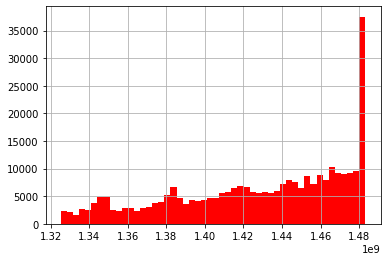

In [167]:
df_fecha['timestamp'].hist(bins=50, color='r'); 

In [168]:
# Vamos a escalar la columna timestamp entre 0 y 1, y lo mismo con la columna aniomes.

In [169]:
tmin = df_fecha['timestamp'].min()
df_fecha['timestamp_scaled'] = df_fecha['timestamp'].map(lambda x: x-tmin)
tmax = df_fecha['timestamp_scaled'].max()
df_fecha['timestamp_scaled'] = df_fecha['timestamp_scaled'].map(lambda x: x/tmax)

In [170]:
tmin = df_fecha['aniomes'].min()
df_fecha['aniomes_scaled'] = df_fecha['aniomes'].map(lambda x: x-tmin)
tmax = df_fecha['aniomes_scaled'].max()
df_fecha['aniomes_scaled'] = df_fecha['aniomes_scaled'].map(lambda x: x/tmax)

In [171]:
df_fecha.head()

,anio,mes,dia,timestamp,aniomes,precio_promedio_metrocubierto_aniomes,precio_promedio_metrocubierto_mes,timestamp_scaled,aniomes_scaled
id,,,,,,,,,
254099,2015,8,23,1.440299e+09,201508,16183,15363,0.728368,0.746959
53461,2013,6,28,1.372388e+09,201306,14297,15521,0.297919,0.255474
247984,2015,10,17,1.445051e+09,201510,15996,15547,0.758488,0.751825
209067,2012,3,9,1.331262e+09,201203,13039,15423,0.037240,0.004866
185997,2016,6,7,1.465268e+09,201606,16142,15521,0.886637,0.985401


In [172]:
dicc_fecha[0] = df_fecha.columns.to_list()
dicc_fecha[1] = ['anio', 'mes', 'dia']
dicc_fecha[2] = ['anio', 'mes', 'aniomes', 'aniomes_scaled']
dicc_fecha[3] = ['anio', 'mes', 'timestamp', 'timestamp_scaled']
dicc_fecha[4] = ['timestamp_scaled', 'aniomes_scaled']
dicc_fecha[5] = ['anio', 'mes', 'timestamp_scaled', 'aniomes_scaled']
dicc_fecha[6] = ['anio', 'mes', 'precio_promedio_metrocubierto_aniomes', 'precio_promedio_metrocubierto_mes',
                 'timestamp_scaled', 'aniomes_scaled']

dicc_fecha_types['uint8'] = ['mes', 'dia']
dicc_fecha_types['uint16'] = ['anio', 'precio_promedio_metrocubierto_aniomes',
                            'precio_promedio_metrocubierto_mes']
dicc_fecha_types['uint32'] = ['aniomes']
dicc_fecha_types['float'] = ['timestamp', 'timestamp_scaled', 'aniomes_scaled']

In [173]:
# Generaremos ahora OHE para aniomes.
encoder = ce.OneHotEncoder()
encoded = encoder.fit_transform(df_fecha['aniomes'].astype('category')).add_suffix("_ohe")

dicc_fecha[7] = encoded.columns.to_list()
dicc_fecha_types['bernoulli'] = dicc_fecha[7]
df_fecha = df_fecha.join(encoded, on='id')

In [174]:
df_fecha.to_csv('features/fecha.csv')

In [175]:
def get_dicc_fecha():
    return {0: ['anio', 'mes', 'dia', 'timestamp', 'aniomes', 'precio_promedio_metrocubierto_aniomes',
  'precio_promedio_metrocubierto_mes', 'timestamp_scaled', 'aniomes_scaled'],
 1: ['anio', 'mes', 'dia'],
 2: ['anio', 'mes', 'aniomes', 'aniomes_scaled'],
 3: ['anio', 'mes', 'timestamp', 'timestamp_scaled'],
 4: ['timestamp_scaled', 'aniomes_scaled'],
 5: ['anio', 'mes', 'timestamp_scaled', 'aniomes_scaled'],
 6: ['anio',  'mes',  'precio_promedio_metrocubierto_aniomes',  'precio_promedio_metrocubierto_mes',
  'timestamp_scaled',  'aniomes_scaled'],
 7: ['aniomes_1_ohe',  'aniomes_2_ohe',  'aniomes_3_ohe',  'aniomes_4_ohe',  'aniomes_5_ohe',  'aniomes_6_ohe',
  'aniomes_7_ohe',  'aniomes_8_ohe',  'aniomes_9_ohe',  'aniomes_10_ohe',  'aniomes_11_ohe',  'aniomes_12_ohe',
  'aniomes_13_ohe',  'aniomes_14_ohe',  'aniomes_15_ohe',  'aniomes_16_ohe',  'aniomes_17_ohe',  'aniomes_18_ohe',
  'aniomes_19_ohe',  'aniomes_20_ohe',  'aniomes_21_ohe',  'aniomes_22_ohe',  'aniomes_23_ohe',  'aniomes_24_ohe',
  'aniomes_25_ohe',  'aniomes_26_ohe',  'aniomes_27_ohe',  'aniomes_28_ohe',  'aniomes_29_ohe',  'aniomes_30_ohe',
  'aniomes_31_ohe',  'aniomes_32_ohe',  'aniomes_33_ohe',  'aniomes_34_ohe',  'aniomes_35_ohe',  'aniomes_36_ohe',
  'aniomes_37_ohe',  'aniomes_38_ohe',  'aniomes_39_ohe',  'aniomes_40_ohe',  'aniomes_41_ohe',  'aniomes_42_ohe',
  'aniomes_43_ohe',  'aniomes_44_ohe',  'aniomes_45_ohe',  'aniomes_46_ohe',  'aniomes_47_ohe',  'aniomes_48_ohe',
  'aniomes_49_ohe',  'aniomes_50_ohe',  'aniomes_51_ohe',  'aniomes_52_ohe',  'aniomes_53_ohe',  'aniomes_54_ohe',
  'aniomes_55_ohe',  'aniomes_56_ohe',  'aniomes_57_ohe',  'aniomes_58_ohe',  'aniomes_59_ohe',  'aniomes_60_ohe']}

In [176]:
def get_dicc_fecha_types():
    return {'uint8': ['mes', 'dia'],
 'uint16': ['anio',
  'precio_promedio_metrocubierto_aniomes',
  'precio_promedio_metrocubierto_mes'],
 'uint32': ['aniomes'],
 'float': ['timestamp', 'timestamp_scaled', 'aniomes_scaled'],
 'bernoulli': ['aniomes_1_ohe',  'aniomes_2_ohe',  'aniomes_3_ohe',  'aniomes_4_ohe',  'aniomes_5_ohe',
  'aniomes_6_ohe',  'aniomes_7_ohe',  'aniomes_8_ohe',  'aniomes_9_ohe',  'aniomes_10_ohe',  'aniomes_11_ohe',
  'aniomes_12_ohe',  'aniomes_13_ohe',  'aniomes_14_ohe',  'aniomes_15_ohe',  'aniomes_16_ohe',  'aniomes_17_ohe',
  'aniomes_18_ohe',  'aniomes_19_ohe',  'aniomes_20_ohe',  'aniomes_21_ohe',  'aniomes_22_ohe',  'aniomes_23_ohe',
  'aniomes_24_ohe',  'aniomes_25_ohe',  'aniomes_26_ohe',  'aniomes_27_ohe',  'aniomes_28_ohe',  'aniomes_29_ohe',
  'aniomes_30_ohe',  'aniomes_31_ohe',  'aniomes_32_ohe',  'aniomes_33_ohe',  'aniomes_34_ohe',  'aniomes_35_ohe',
  'aniomes_36_ohe',  'aniomes_37_ohe',  'aniomes_38_ohe',  'aniomes_39_ohe',  'aniomes_40_ohe',  'aniomes_41_ohe',
  'aniomes_42_ohe',  'aniomes_43_ohe',  'aniomes_44_ohe',  'aniomes_45_ohe',  'aniomes_46_ohe',  'aniomes_47_ohe',
  'aniomes_48_ohe',  'aniomes_49_ohe',  'aniomes_50_ohe',  'aniomes_51_ohe',  'aniomes_52_ohe',  'aniomes_53_ohe',
  'aniomes_54_ohe',  'aniomes_55_ohe',  'aniomes_56_ohe',  'aniomes_57_ohe',  'aniomes_58_ohe',  'aniomes_59_ohe',  'aniomes_60_ohe']}

### DESCRIPCION

In [177]:
# La idea es analizar la descripcion en busqueda de data interesante que no este incorporada en el
# dataset original. Para esto, procesaremos el texto en busqueda de indicadores.

dicc_descripcion = {}
dicc_descripcion_types = {}

df_descripcion = df[['descripcion', 'titulo']].copy()

In [178]:
indicadores = ["jardin", "patio", "jardín"]
df_descripcion["jardin_des"] = df_descripcion["descripcion"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["jardin_tit"] = df_descripcion["titulo"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["jardin"] = df_descripcion.apply(lambda x: ((x['jardin_des']) | (x['jardin_tit'])), axis=1)

indicadores = ["vigilancia", "seguridad"]
df_descripcion["vigilancia_des"] = df_descripcion["descripcion"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["vigilancia_tit"] = df_descripcion["titulo"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["vigilancia"] = df_descripcion.apply(lambda x: ((x['vigilancia_des']) | (x['vigilancia_tit'])), axis=1)

indicadores = ["aire acondicionado", "aires acondicionados"]
df_descripcion["aire_acondicionado_des"] = df_descripcion["descripcion"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["aire_acondicionado_tit"] = df_descripcion["titulo"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["aire_acondicionado"] = df_descripcion.apply(lambda x: ((x['aire_acondicionado_des']) | (x['aire_acondicionado_tit'])), axis=1)

indicadores = ["ventilador", "ventiladores"]
df_descripcion["ventilador_des"] = df_descripcion["descripcion"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["ventilador_tit"] = df_descripcion["titulo"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["ventilador"] = df_descripcion.apply(lambda x: ((x['ventilador_des']) | (x['ventilador_tit'])), axis=1)

indicadores = ["calefaccion", "caloventor", "estufa", "calefacción", "calentador"]
df_descripcion["calefaccion_des"] = df_descripcion["descripcion"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["calefaccion_tit"] = df_descripcion["titulo"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["calefaccion"] = df_descripcion.apply(lambda x: ((x['calefaccion_des']) | (x['calefaccion_tit'])), axis=1)

indicadores = ["parrilla", "asador", "asado", "parrillada"]
df_descripcion["parrilla_des"] = df_descripcion["descripcion"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["parrilla_tit"] = df_descripcion["titulo"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["parrilla"] = df_descripcion.apply(lambda x: ((x['parrilla_des']) | (x['parrilla_tit'])), axis=1)

indicadores = ["terraza"]
df_descripcion["terraza_des"] = df_descripcion["descripcion"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["terraza_tit"] = df_descripcion["titulo"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["terraza"] = df_descripcion.apply(lambda x: ((x['terraza_des']) | (x['terraza_tit'])), axis=1)

indicadores = ["jacuzzi", "sauna"]
df_descripcion["lujo_des"] = df_descripcion["descripcion"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["lujo_tit"] = df_descripcion["titulo"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["lujo"] = df_descripcion.apply(lambda x: ((x['lujo_des']) | (x['lujo_tit'])), axis=1)

indicadores = ["cuarto de servicio", "salon de servicio", "salón de servicio", "salon servicio",
              "salón servicio", "cuarto servicio", "sala servicio", "sala de servicio"]
df_descripcion["servicio_des"] = df_descripcion["descripcion"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["servicio_tit"] = df_descripcion["titulo"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["servicio"] = df_descripcion.apply(lambda x: ((x['servicio_des']) | (x['servicio_tit'])), axis=1)


drop_list = ['jardin_des', 'jardin_tit', 'vigilancia_des', 'vigilancia_tit', 'aire_acondicionado_des',
            'aire_acondicionado_tit', 'ventilador_des', 'ventilador_tit', 'calefaccion_des', 'calefaccion_tit',
            'parrilla_des', 'parrilla_tit', 'terraza_des', 'terraza_tit', 'lujo_des', 'lujo_tit',
            'servicio_des', 'servicio_tit']
df_descripcion.drop(drop_list, axis=1, inplace=True)

In [179]:
df_descripcion[['jardin', 'vigilancia', 'aire_acondicionado', 'ventilador', 'calefaccion', 'parrilla', 'terraza', 'lujo', 'servicio']].sum()

jardin                128653
vigilancia             66033
aire_acondicionado      8302
ventilador              3503
calefaccion            17439
parrilla               17634
terraza                54148
lujo                   12926
servicio               50057
dtype: int64

In [180]:
df_descripcion.drop(['titulo', 'descripcion'], axis=1, inplace=True)

In [181]:
columnas = df_descripcion.columns.to_list()

In [182]:
dicc_descripcion[0] = columnas
dicc_descripcion_types['bernoulli'] = columnas

In [183]:
# guardamos el csv
df_descripcion.to_csv('features/descripcion.csv')

In [184]:
def get_dicc_descripcion():
    return {0: ['jardin',  'vigilancia',  'aire_acondicionado',  'ventilador',  'calefaccion',
  'parrilla',  'terraza',  'lujo',  'servicio']}

In [185]:
def get_dicc_descripcion_types():
    return {'bernoulli': ['jardin',  'vigilancia',  'aire_acondicionado',  'ventilador',  'calefaccion',
  'parrilla',  'terraza',  'lujo',  'servicio']}

### METRICAS DE LOS FEATURES

In [17]:
dicc_metricas = {}
dicc_metricas_types = {}

df_metricas = df[['metroscubiertos','ciudad', 'tipodepropiedad']].copy().reset_index()

##### MEAN Y STD DE SUPERFICIE CUBIERTA POR CIUDAD

In [18]:
avg_metroscubiertos = df_metricas.groupby('ciudad').agg({"metroscubiertos":["mean","std"]}).reset_index()
avg_metroscubiertos.columns = ['ciudad','metroscubiertos_mean','metroscubiertos_std']
df_metricas = pd.merge(df_metricas,avg_metroscubiertos,how='inner',on='ciudad')

In [19]:
dicc_metricas[0] = ['metroscubiertos_mean', 'metroscubiertos_std']
dicc_metricas_types['float'] = ['metroscubiertos_mean', 'metroscubiertos_std']

##### MEAN Y STD DE SUPERFICIE CUBIERTA POR TIPO DE PROPIEDAD

In [20]:
avg_metroscubiertos_tipo = df_metricas.groupby('tipodepropiedad').agg({"metroscubiertos":["mean","std"]}).reset_index()
avg_metroscubiertos_tipo.columns = ['tipodepropiedad','metroscubiertos_city_mean','metroscubiertos_city_std']
df_metricas = pd.merge(df_metricas,avg_metroscubiertos_tipo,how='inner',on='tipodepropiedad').set_index('id')
df_metricas.drop(['metroscubiertos', 'tipodepropiedad', 'ciudad'], axis=1, inplace=True)

In [21]:
dicc_metricas[1] = ['metroscubiertos_city_mean', 'metroscubiertos_city_std']
dicc_metricas_types['float'] += ['metroscubiertos_city_mean', 'metroscubiertos_city_std']

In [22]:
# Combinaciones adicionales

dicc_metricas[2] = ['metroscubiertos_city_mean', 'metroscubiertos_city_std', 'metroscubiertos_mean', 'metroscubiertos_std']

In [23]:
# guardamos el csv
df_metricas.to_csv('features/metricas.csv')

In [26]:
def get_dicc_metricas():
    return {0: ['metroscubiertos_mean', 'metroscubiertos_std'],
 1: ['metroscubiertos_city_mean', 'metroscubiertos_city_std'],
 2: ['metroscubiertos_city_mean',  'metroscubiertos_city_std',  'metroscubiertos_mean',  'metroscubiertos_std']}

In [28]:
def get_dicc_metricas_types():
    return {'float': ['metroscubiertos_mean',
  'metroscubiertos_std',  'metroscubiertos_city_mean',  'metroscubiertos_city_std']}

### BINNING (+OHE)

In [194]:
# binning para antiguedad
dicc_antiguedad = {}
dicc_antiguedad_types = {}

df_antiguedad = df[['antiguedad']].copy()

In [195]:
# binning general (9 bins)
df_antiguedad['antiguedad'].fillna(-1, inplace=True)
df_antiguedad['antiguedad'] = df_antiguedad['antiguedad'].astype(int)
df_antiguedad['antiguedad_binning'] = df_antiguedad['antiguedad'].map(lambda x: binning_antiguedad_1(x))

In [196]:
# ohe
encoder = ce.OneHotEncoder()
encoded = encoder.fit_transform(df_antiguedad['antiguedad_binning']).add_suffix("_ohe1")

dicc_antiguedad[0] = encoded.columns.to_list()
dicc_antiguedad_types['bernoulli'] = dicc_antiguedad[0]
df_antiguedad = df_antiguedad.join(encoded, on='id')

In [197]:
# binning especifico (4 bins)
df_antiguedad['antiguedad_binning_2'] = df_antiguedad['antiguedad'].map(lambda x: binning_antiguedad_2(x))

In [198]:
# ohe
encoder = ce.OneHotEncoder()
encoded = encoder.fit_transform(df_antiguedad['antiguedad_binning_2']).add_suffix("_ohe2")

dicc_antiguedad[1] = encoded.columns.to_list()
dicc_antiguedad_types['bernoulli'] += dicc_antiguedad[1]
df_antiguedad = df_antiguedad.join(encoded, on='id')
df_antiguedad.drop(['antiguedad', 'antiguedad_binning', 'antiguedad_binning_2'], axis=1, inplace=True)

In [199]:
# guardamos el csv
df_antiguedad.to_csv('features/antiguedad.csv')

In [200]:
def get_dicc_antiguedad():
    return {0: ['antiguedad_binning_1_ohe1',  'antiguedad_binning_2_ohe1',  'antiguedad_binning_3_ohe1',
  'antiguedad_binning_4_ohe1',  'antiguedad_binning_5_ohe1',  'antiguedad_binning_6_ohe1',
  'antiguedad_binning_7_ohe1',  'antiguedad_binning_8_ohe1',  'antiguedad_binning_9_ohe1',
  'antiguedad_binning_2_1_ohe2',  'antiguedad_binning_2_2_ohe2',  'antiguedad_binning_2_3_ohe2',  'antiguedad_binning_2_4_ohe2'],
 1: ['antiguedad_binning_2_1_ohe2',  'antiguedad_binning_2_2_ohe2',  'antiguedad_binning_2_3_ohe2',  'antiguedad_binning_2_4_ohe2']}

In [201]:
def get_dicc_antiguedad_types():
    return {'bernoulli': ['antiguedad_binning_1_ohe1',  'antiguedad_binning_2_ohe1',  'antiguedad_binning_3_ohe1',
  'antiguedad_binning_4_ohe1',  'antiguedad_binning_5_ohe1',  'antiguedad_binning_6_ohe1',
  'antiguedad_binning_7_ohe1',  'antiguedad_binning_8_ohe1',  'antiguedad_binning_9_ohe1',
  'antiguedad_binning_2_1_ohe2',  'antiguedad_binning_2_2_ohe2',  'antiguedad_binning_2_3_ohe2',  'antiguedad_binning_2_4_ohe2']}

In [202]:
# binning para habitaciones
dicc_habitaciones = {}
dicc_habitaciones_types = {}

df_habitaciones = df[['habitaciones']].copy()

In [203]:
df_habitaciones['habitaciones'].fillna(-1, inplace=True)
df_habitaciones['habitaciones'] = df_habitaciones['habitaciones'].astype(int)
df_habitaciones['hab_binning'] = df_habitaciones['habitaciones'].map(lambda x: binning_habitaciones(x))

In [204]:
# ohe
encoder = ce.OneHotEncoder()
encoded = encoder.fit_transform(df_habitaciones['hab_binning']).add_suffix("_ohe")

dicc_habitaciones[0] = encoded.columns.to_list()
dicc_habitaciones_types['bernoulli'] = dicc_habitaciones[0]
df_habitaciones = encoded

In [205]:
df_habitaciones.to_csv('features/habitaciones.csv')

In [206]:
def get_dicc_habitaciones():
    return {0: ['hab_binning_1_ohe',  'hab_binning_2_ohe',  'hab_binning_3_ohe',  'hab_binning_4_ohe',
  'hab_binning_5_ohe',  'hab_binning_6_ohe',  'hab_binning_7_ohe']}

In [207]:
def get_dicc_habitaciones_types():
    return {'bernoulli': ['hab_binning_1_ohe',  'hab_binning_2_ohe',  'hab_binning_3_ohe',  'hab_binning_4_ohe',
  'hab_binning_5_ohe',  'hab_binning_6_ohe',  'hab_binning_7_ohe']}

### COTIZACION DEL USD

In [208]:
# Quizas resulte de interes conocer la cotizacion del dolar en pesos mexicanos, ya que el dolar se toma 
# como moneda de referencia en el mercado inmobiliario en gran parte de America.

# Para eso, se utilizo un dataset de https://es.investing.com/currencies/usd-mxn-historical-data

dicc_extras = {}
dicc_extras_types = {}

df_extras = df_fecha[['aniomes']].copy().reset_index()

In [209]:
# Cargamos el dataset preprocesado en pre_processing.
usd = pd.read_csv('data/usd_mxn_featured.csv', index_col=['aniomes'])

In [210]:
usd['usd_var_mesanterior'] = usd['usd_varianza'].shift(1).fillna(0)
usd['usd_daily_mean_mesanterior'] = usd['daily_mean'].shift(1).fillna(0)

In [211]:
df_extras = pd.merge(df_extras, usd, on='aniomes', how='left').drop('aniomes', axis=1).set_index('id')

In [212]:
df_extras['usd_subio'] = df_extras.apply(lambda x: 1 if (x['usd_daily_mean_mesanterior']<x['daily_mean']) else 0, axis=1)

In [213]:
df_extras.drop('usd_daily_mean_mesanterior', inplace=True, axis=1)

In [214]:
df_extras.head()

,usd_varianza,daily_mean,usd_var_mesanterior,usd_subio
id,,,,
254099,3.96,16.551050,2.37,1
53461,1.16,12.955530,5.46,1
247984,-2.48,16.586802,1.08,0
209067,-0.27,12.734559,-1.50,0
185997,-0.82,18.640750,7.34,1


In [215]:
df_extras.columns = ['usd_variacion', 'usd_precio_promedio_mensual', 'usd_variacion_mes_anterior', 'usd_subio']

In [216]:
dicc_extras[0] = df_extras.columns.to_list()
dicc_extras[1] = ['usd_subio']
dicc_extras[2] = ['usd_precio_promedio_mensual', 'usd_subio']

dicc_extras_types['float'] = ['usd_variacion', 'usd_precio_promedio_mensual', 'usd_variacion_mes_anterior']
dicc_extras_types['bernoulli'] = ['usd_subio']

In [217]:
df_extras.to_csv('features/extras.csv')

In [218]:
dicc_extras_types

{'float': ['usd_variacion',
  'usd_precio_promedio_mensual',
  'usd_variacion_mes_anterior'],
 'bernoulli': ['usd_subio']}

In [219]:
def get_dicc_extras():
    return {0: ['usd_variacion',
  'usd_precio_promedio_mensual',
  'usd_variacion_mes_anterior',
  'usd_subio'],
 1: ['usd_subio'],
 2: ['usd_precio_promedio_mensual', 'usd_subio']}

In [220]:
def get_dicc_extras_types():
    return {'float': ['usd_variacion',
  'usd_precio_promedio_mensual',
  'usd_variacion_mes_anterior'],
 'bernoulli': ['usd_subio']}

### VOLCANES CERCANOS

In [221]:
dicc_volcanes = {}
dicc_volcanes_types = {}

df_volcanes = df[['lat', 'lng']].copy()

In [223]:
from haversine import haversine
volcanes = pd.read_csv('data/volcanes_featured.csv')

In [224]:
volcanes['punto'] = volcanes.apply(lambda x: (x['lat'], x['long']), axis=1)
volcanes = volcanes['punto'].to_list()

In [225]:
df_volcanes['lat'].fillna(9999, inplace=True)
df_volcanes['lng'].fillna(9999, inplace=True)

In [226]:
df_volcanes['ubicacion'] = df_volcanes.apply(lambda x: (x['lat'], x['lng']) if ((x['lat'] != 9999) & (x['lng'] != 9999)) else 9999, axis=1)

In [227]:
df_volcanes['volcan_cerca'] = df_volcanes['ubicacion'].map(lambda x: posee_volcan_cerca(x, 20))
df_volcanes['volcanes_cerca'] = df_volcanes['ubicacion'].map(lambda x: cantidad_volcanes_cerca(x, 20))

In [228]:
df_volcanes.drop(['lat', 'lng', 'ubicacion'], inplace=True, axis=1)

In [229]:
dicc_volcanes[0] = df_volcanes.columns.to_list()
dicc_volcanes_types['float'] = df_volcanes.columns.to_list()

In [230]:
df_volcanes.to_csv('features/volcanes.csv')

In [231]:
def get_dicc_volcanes():
    return {0: ['volcan_cerca', 'volcanes_cerca']}

In [232]:
def get_dicc_volcanes_types():
    return {'float': ['volcan_cerca', 'volcanes_cerca']}

## Target Mean Encoding para idzona

In [233]:
dicc_idzona = {}
dicc_idzona_types = {}

df_idzona_target = df[['idzona','precio']].copy().reset_index()

In [234]:
idzona_mean_price = df.groupby('idzona').agg({"precio":'mean'}).reset_index()

In [235]:
idzona_mean_price.columns = ['idzona','idzona_mean_price']

In [236]:
df_idzona_target_merged = pd.merge(df_idzona_target,idzona_mean_price,on='idzona',how='left')

In [237]:
df_idzona_target_merged.set_index('id',inplace=True)

In [238]:
df_idzona_target_merged = df_idzona_target_merged[['idzona_mean_price']]

In [239]:
dicc_idzona[0] = df_idzona_target_merged.columns.to_list()
dicc_idzona_types['float'] = df_idzona_target_merged.columns.to_list()

In [240]:
df_idzona_target_merged.to_csv('features/idzona.csv')

In [241]:
def get_dicc_idzona():
    return {0: ['idzona_mean_price']}

In [242]:
def get_dicc_idzona_types():
    return {'float':['idzona_mean_price']}

<hr>

# Resultados
Como mencionamos antes, para evitar tener que ejecutar todo el notebook nuevamente (proceso costoso en tiempo, que ya se ejecuto antes) hardcodeamos los siguientes diccionarios y listas que seran utilizadas en otros notebooks.

In [243]:
def get_csvs_names():
    return ['metros', 'tipodepropiedad', 'provincia', 'ciudad', 'fecha', 'descripcion', 'metricas',
            'habitaciones', 'antiguedad', 'extras', 'volcanes', 'idzona']

In [244]:
def get_features():
    dicc_list = [get_dicc_metros, get_dicc_tipodepropiedad, get_dicc_provincia, get_dicc_ciudad,
                    get_dicc_fecha, get_dicc_descripcion, get_dicc_metricas, get_dicc_habitaciones,
                    get_dicc_antiguedad, get_dicc_extras, get_dicc_volcanes, get_dicc_idzona]
    features = {}
    features['metros'] = get_dicc_metros()
    features['tipodepropiedad'] = get_dicc_tipodepropiedad()
    features['provincia'] = get_dicc_provincia()
    features['ciudad'] = get_dicc_ciudad()
    features['fecha'] = get_dicc_fecha()
    features['descripcion'] = get_dicc_descripcion()
    features['metricas'] = get_dicc_metricas()
    features['habitaciones'] = get_dicc_habitaciones()
    features['antiguedad'] = get_dicc_antiguedad()
    features['extras'] = get_dicc_extras()
    features['volcanes'] = get_dicc_volcanes()
    features['idzona'] = get_dicc_idzona()
    return features

In [245]:
def get_features_types():
    get_dicc_types_list = [get_dicc_metros_types, get_dicc_tipodepropiedad_types, get_dicc_provincia_types,
                          get_dicc_ciudad_types, get_dicc_fecha_types, get_dicc_descripcion_types,
                          get_dicc_metricas_types, get_dicc_habitaciones_types, get_dicc_antiguedad_types,
                          get_dicc_extras_types, get_dicc_idzona_types]
    types = {}
    types['metros'] = get_dicc_metros_types()
    types['tipodepropiedad'] = get_dicc_tipodepropiedad_types()
    types['provincia'] = get_dicc_provincia_types()
    types['ciudad'] = get_dicc_ciudad_types()
    types['fecha'] = get_dicc_fecha_types()
    types['descripcion'] = get_dicc_descripcion_types()
    types['metricas'] = get_dicc_metricas_types()
    types['habitaciones'] = get_dicc_habitaciones_types()
    types['antiguedad'] = get_dicc_antiguedad_types()
    types['extras'] = get_dicc_extras_types()
    types['volcanes'] = get_dicc_volcanes_types()
    types['idzona'] = get_dicc_idzona_types()
    return types